# Classifying Galaxies


**Author:** Gavin DeBrun

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import jit
import  jax
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
import itertools
from IPython.display import HTML
import pickle
import datetime;datetime.datetime.now()
def resetMe(keepList=[]):
    ll=%who_ls
    keepList=keepList+['resetMe','np','plt','math','FuncAnimation',
                       'HTML','itertools','pickle','testFunc','jnp','jax','jit']
    for iiii in keepList:
        if iiii in ll:
            ll.remove(iiii)
    for iiii in ll:
        jjjj="^"+iiii+"$"
        %reset_selective -f {jjjj}
    ll=%who_ls
    return

## Machine Learning on Galaxies

In [2]:
!wget https://courses.physics.illinois.edu/phys246/fa2020/code/dataG.pkl.gz

--2021-02-28 18:29:05--  https://courses.physics.illinois.edu/phys246/fa2020/code/dataG.pkl.gz
Resolving courses.physics.illinois.edu (courses.physics.illinois.edu)... 130.126.151.14
Connecting to courses.physics.illinois.edu (courses.physics.illinois.edu)|130.126.151.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84647509 (81M) [application/x-gzip]
Saving to: ‘dataG.pkl.gz’

dataG.pkl.gz        100%[===================>]  80.73M  1.82MB/s    in 46s     

2021-02-28 18:29:51 (1.77 MB/s) - ‘dataG.pkl.gz’ saved [84647509/84647509]



In [3]:
%%time
import gzip
#(train_images_raw,train_labels,test_images_raw,test_labels) = pickle.load(gzip.open("dataG.pkl.gz",'rb'))
!wget https://courses.physics.illinois.edu/phys246/fa2020/code/data.pkl.zip
!unzip data.pkl.zip
(train_images_raw,train_labels,test_images_raw,test_labels) = pickle.load(open("data.pkl",'rb'))

--2021-02-28 18:29:51--  https://courses.physics.illinois.edu/phys246/fa2020/code/data.pkl.zip
Resolving courses.physics.illinois.edu (courses.physics.illinois.edu)... 130.126.151.14
Connecting to courses.physics.illinois.edu (courses.physics.illinois.edu)|130.126.151.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299353957 (285M) [application/x-zip-compressed]
Saving to: ‘data.pkl.zip’

data.pkl.zip        100%[===================>] 285.49M  1.79MB/s    in 3m 16s  

2021-02-28 18:33:07 (1.46 MB/s) - ‘data.pkl.zip’ saved [299353957/299353957]

Archive:  data.pkl.zip
  inflating: data.pkl                
   creating: __MACOSX/
  inflating: __MACOSX/._data.pkl     
CPU times: user 3.97 s, sys: 2.17 s, total: 6.15 s
Wall time: 3min 24s



* `train_images_raw` - images in the training set, shape: (17457, 69, 69, 1)
* `train_labels`     - labels that explain the image classification for the training set
* `test_images_raw`  - images for the test set, shape: (1940,69,69,1)
* `test_labels`      - labels that explain the image classification for the test set

### a. Galaxies

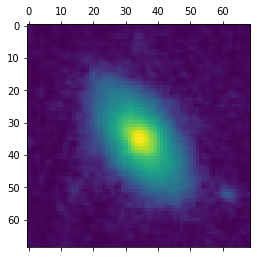

In [4]:
plt.matshow(train_images_raw[0][:,:,0])
plt.show()

In [5]:
print(train_labels[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]



```
Galaxy10 dataset (25753 images)
├── *0* Class 0 (3461 images): Disk, Face-on, No Spiral
├── *1* Class 1 (6997 images): Smooth, Completely round
├── *2* Class 2 (6292 images): Smooth, in-between round
├── Class 3 (394 images): Smooth, Cigar shaped
├── *3* Class 4 (3060 images): Disk, Edge-on, Rounded Bulge
├── Class 5 (17 images): Disk, Edge-on, Boxy Bulge
├── Class 6 (1089 images): Disk, Edge-on, No Bulge
├── *4* Class 7 (1932 images): Disk, Face-on, Tight Spiral
├── Class 8 (1466 images): Disk, Face-on, Medium Spiral
└── Class 9 (1045 images): Disk, Face-on, Loose Spiral
```
![Galaxy10 dataset](https://astronn.readthedocs.io/en/latest/_images/galaxy10_example.png)

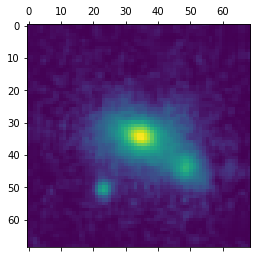

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
plt.matshow(train_images_raw[98][:,:,0])
plt.show()
print(train_labels[98])

In [7]:
print(np.shape(train_images_raw))

(19606, 69, 69, 3)


In [8]:
train_images=train_images_raw.reshape(len(train_images_raw),69*69*3)
train_images /= 256

test_images = test_images_raw.reshape(len(test_images_raw), 69*69*3)
test_images /= 256

### b. Neural Network

In [9]:
params = dict()
d = 100
params["W1"] = .1*np.random.randn(d, 69*69*3)
params["W2"] = .1*np.random.randn(10,d)
params["b1"] = .1*np.random.randn(d)
params["b2"] = .1*np.random.rand(10)

def net(params, imageVector):
  W1=params["W1"]
  b1=params["b1"]
  W2= params["W2"]
  b2 = params["b2"]
  output = 1.0 / (1.0 + jnp.exp(-(W2 @ jnp.tanh(W1 @ imageVector + b1) + b2)))
  return output

print("output vector:", net(params, train_images[3]), "classification number:", np.argmax(net(params, train_images[3])))

output vector: [0.4548924  0.44674426 0.9022572  0.41935694 0.16386952 0.08757319
 0.24857341 0.28029463 0.27153912 0.30566087] classification number: 2


/Users/gavin/opt/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### c. A measure of goodness

In [10]:
@jit
def loss(params, imageVector, correctLabel):
  networkLabel = net(params, imageVector)
  cross_entropy = jnp.sum(-correctLabel * jnp.log(networkLabel) - (1.0 - correctLabel) * jnp.log( 1.0 - networkLabel))
  return cross_entropy

i = 0
print(loss(params, train_images[i], train_labels[i]))

4.936081


In [11]:
def fractionCorrect(params, images, labels):
  numberCorrect = 0
  for i in range(len(images)):
    networkLabel = np.argmax(net(params, images[i]))
    if networkLabel == np.argmax(labels[i]):
      numberCorrect += 1
  return numberCorrect / len(images)
print(fractionCorrect(params,test_images,test_labels))

0.2588343276732446


### d. Classification

In [13]:
%%time
d = 100
n = 100*2000
params = dict()
params["W1"] = .1*np.random.randn(d, 69*69*3)
params["W2"] = .1*np.random.randn(10,d)
params["b1"] = .1*np.random.randn(d)
params["b2"] = .1*np.random.rand(10)

loss_grad = jit(jax.grad(jit(loss)))
accuracy = []
steps = []
for i in range(n):
  imageIndex = np.random.randint(0, len(train_images))
  gradient = loss_grad(params, train_images[imageIndex], train_labels[imageIndex])
  params["W1"] += -.001*gradient["W1"]
  params["W2"] += -.001*gradient["W2"]
  params["b1"] += -.001*gradient["b1"]
  params["b2"] += -.001*gradient["b2"]
  if i % 2000 == 0:
    accuracy.append(fractionCorrect(params, test_images, test_labels))
    steps.append(i)

CPU times: user 26min 13s, sys: 4min 36s, total: 30min 50s
Wall time: 11min 42s


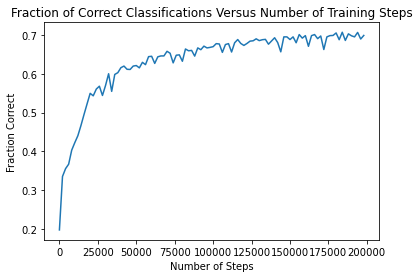

In [14]:
plt.plot(steps, accuracy)
plt.xlabel("Number of Steps")
plt.ylabel("Fraction Correct")
plt.title("Fraction of Correct Classifications Versus Number of Training Steps")
plt.show()

### e.  Mini-batches and vmap 

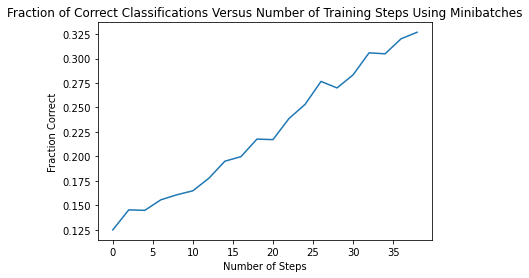

CPU times: user 1min 26s, sys: 17.8 s, total: 1min 44s
Wall time: 1min 18s


In [ ]:
%%time

d = 100
params = dict()
params["W1"] = .1*np.random.randn(d, 69*69)
params["W2"] = .1*np.random.randn(5,d)
params["b1"] = .1*np.random.randn(d)
params["b2"] = .1*np.random.rand(5)

def miniBatch(images, labels, batchSize):
  W1_grad = jnp.zeros([d,69*69])
  W2_grad = jnp.zeros([5,d])
  b1_grad = jnp.array([d])
  b2_grad = jnp.array([5])
  for i in range(batchSize):
    imageIndex = np.random.randint(0,len(images))
    grad = loss_grad(params, images[imageIndex], labels[imageIndex])
    W1_grad += grad["W1"]
    W2_grad += grad["W2"]
    b1_grad += grad["b1"]
    b2_grad += grad["b2"]
  return W1_grad/batchSize, W2_grad/batchSize, b1_grad/batchSize, b2_grad/batchSize

accuracy = []
steps = []
loss_grad = jit(jax.grad(jit(loss)))

for i in range(40):
  gradient = miniBatch(train_images, train_labels, 10)
  params["W1"] += -.001*gradient[0]
  params["W2"] += -.001*gradient[1]
  params["b1"] += -.001*gradient[2]
  params["b2"] += -.001*gradient[3]
  if i % 2 == 0:
    accuracy.append(fractionCorrect(params, test_images, test_labels))
    steps.append(i)

plt.plot(steps, accuracy)
plt.xlabel("Number of Steps")
plt.ylabel("Fraction Correct")
plt.title("Fraction of Correct Classifications Versus Number of Training Steps Using Minibatches")
plt.show()

In [ ]:
%%time

def net(params, imageVector):
  W1=params[0]
  b1=params[2]
  W2= params[1]
  b2 = params[3]
  output = 1.0 / (1.0 + jnp.exp(-(W2 @ jnp.tanh(W1 @ imageVector + b1) + b2)))
  return output



loss_grad = jax.jit(jax.vmap(jax.grad(loss), in_axes=( None, 0, 0), out_axes=0))
d = 100
learning_rate = .001
params = dict()
params["W1"] = .1*np.random.randn(d, 69*69)
params["W2"] = .1*np.random.randn(5,d)
params["b1"] = .1*np.random.randn(d)
params["b2"] = .1*np.random.rand(5)
batchSize = 10
accuracy = []
steps = []
params = [params["W1"], params["W2"], params["b1"], params["b2"]]
for i in range(10*200):
  batchIndices = np.random.randint(0, len(train_images), size = batchSize)
  #imageBatch = [train_images[i] for i in batchIndices]
  imageBatch = train_images[batchIndices]
  #labelBatch = [train_labels[i] for i in batchIndices]
  labelBatch = train_labels[batchIndices]
  grads = loss_grad(params, imageBatch, labelBatch)

  params = [param - learning_rate * np.mean(grad, axis=0)
              for param, grad in zip(params, grads)]

  if i % 200 == 0:
    accuracy.append(fractionCorrect(params, test_images, test_labels))
    steps.append(i)


plt.plot(steps, accuracy)
plt.xlabel("Number of Steps")
plt.ylabel("Fraction Correct")
plt.title("Fraction of Correct Classifications Versus Number of Training Steps Using VMap")
plt.show()

### Train and Optimize

--2020-11-12 21:58:07--  https://courses.physics.illinois.edu/phys246/fa2020/code/data.pkl.zip
Resolving courses.physics.illinois.edu (courses.physics.illinois.edu)... 130.126.151.14
Connecting to courses.physics.illinois.edu (courses.physics.illinois.edu)|130.126.151.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299353957 (285M) [application/x-zip-compressed]
Saving to: ‘data.pkl.zip.2’

data.pkl.zip.2      100%[===================>] 285.49M  44.5MB/s    in 7.3s    

2020-11-12 21:58:15 (39.0 MB/s) - ‘data.pkl.zip.2’ saved [299353957/299353957]

Archive:  data.pkl.zip
replace data.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data.pkl                
replace __MACOSX/._data.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace __MACOSX/._data.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._data.pkl     


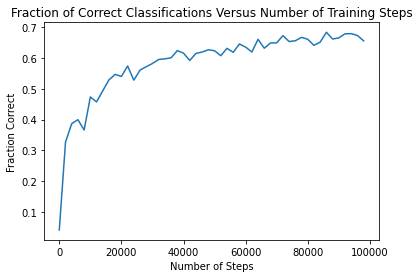

CPU times: user 19min 41s, sys: 2min 38s, total: 22min 19s
Wall time: 14min 4s


In [ ]:
%%time

def net(params, imageVector):
  W1=params["W1"]
  b1=params["b1"]
  W2= params["W2"]
  b2 = params["b2"]
  output = 1.0 / (1.0 + jnp.exp(-(W2 @ jnp.tanh(W1 @ imageVector + b1) + b2)))
  return output

  
!wget https://courses.physics.illinois.edu/phys246/fa2020/code/data.pkl.zip
!unzip data.pkl.zip
(train_images_raw,train_labels,test_images_raw,test_labels) = pickle.load(open("data.pkl",'rb'))

train_images=train_images_raw.reshape(len(train_images_raw),69*69*3)
train_images /= 256

test_images = test_images_raw.reshape(len(test_images_raw), 69*69*3)
test_images /= 256

d = 100
params = dict()
params["W1"] = .1*np.random.randn(d, 69*69*3)
params["W2"] = .1*np.random.randn(10,d)
params["b1"] = .1*np.random.randn(d)
params["b2"] = .1*np.random.rand(10)

loss_grad = jit(jax.grad(jit(loss)))
accuracy = []
steps = []
for i in range(50*2000):
  imageIndex = np.random.randint(0, len(train_images))
  gradient = loss_grad(params, train_images[imageIndex], train_labels[imageIndex])
  params["W1"] += -.001*gradient["W1"]
  params["W2"] += -.001*gradient["W2"]
  params["b1"] += -.001*gradient["b1"]
  params["b2"] += -.001*gradient["b2"]
  if i % 2000 == 0:
    accuracy.append(fractionCorrect(params, test_images, test_labels))
    steps.append(i)

plt.plot(steps, accuracy)
plt.xlabel("Number of Steps")
plt.ylabel("Fraction Correct")
plt.title("Fraction of Correct Classifications Versus Number of Training Steps")
plt.show()